## Nama : Daniel Morantha
## Kelas  : Predict

# 1. Importing packages

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import os

from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

In [2]:
path = './4-animal-classification/'

# 2. Image Acquistion

In [3]:
names = []
nums = []
data = {'Name of class':[],'Number of samples':[]}

for i in os.listdir(path+'/train'):
    nums.append(len(os.listdir(path+'/train/'+i)))
    names.append(i)

data['Name of class']+=names
data['Number of samples']+=nums

df = pd.DataFrame(data)
df

,Name of class,Number of samples
0,cat,700
1,deer,600
2,dog,900
3,horse,600


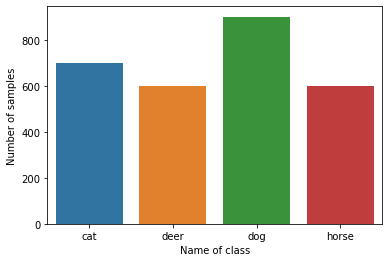

In [4]:
sns.barplot(x=df['Name of class'],y=df['Number of samples'])

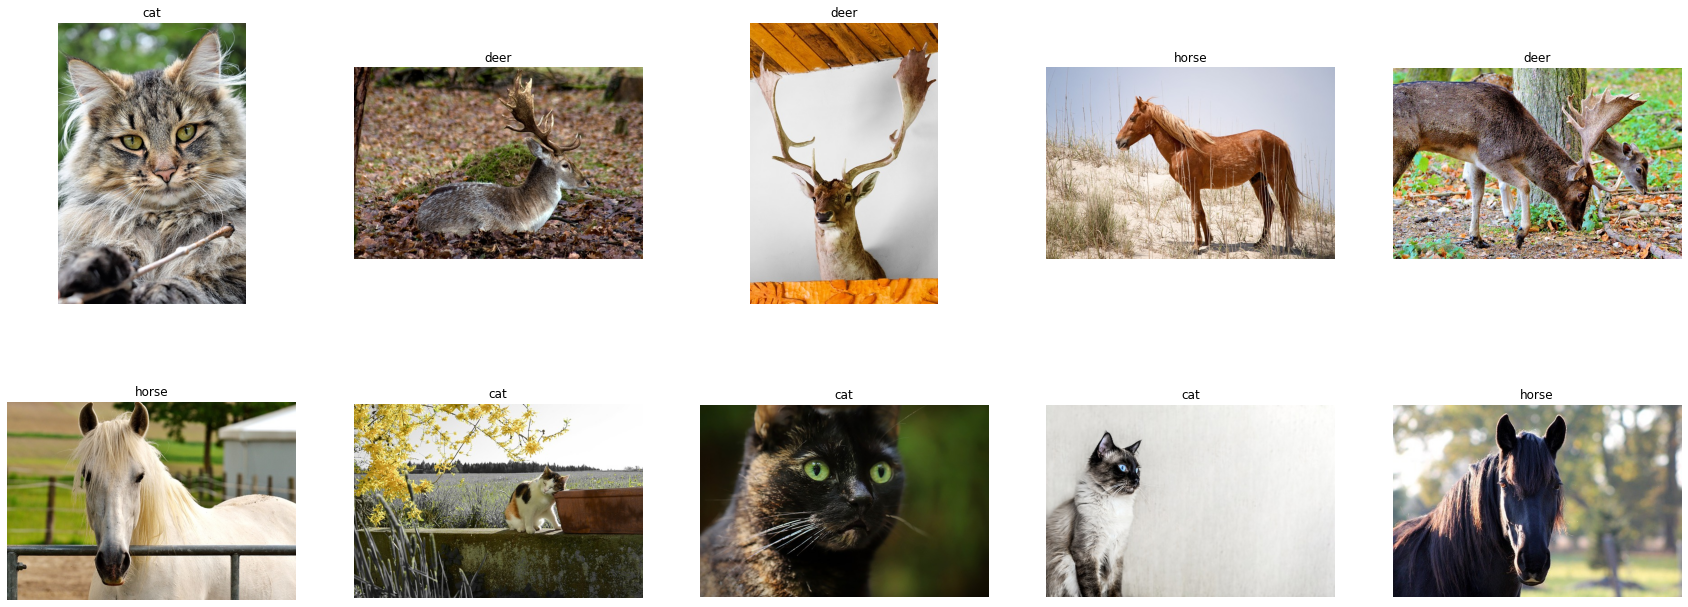

In [6]:
classes = os.listdir(path+'/train')

plt.figure(figsize=(30 , 30))
for x in range(10):
    i = random.randint(0,3)                    # getting the class
    images = os.listdir(path+'/train'+'/'+classes[i])
    j = random.randint(0,600)                  # getting the image
    image = cv2.imread(path+'/train'+'/'+classes[i]+'/'+images[j])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(5, 5, x + 1)
    plt.imshow(image)
    plt.title(classes[i])
    plt.axis("off")

plt.show()

# 3. Pre-processing

In [7]:
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255 , rotation_range=20,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                horizontal_flip=True, validation_split=0.2)

In [8]:
train_ds = image_datagen.flow_from_directory(
        path+'/train',
        subset='training',
        target_size=(224 , 224),
        batch_size=16)

val_ds = image_datagen.flow_from_directory(
        path+'/train',
        subset='validation',
        target_size=(224 , 224),
        batch_size=16 )

Found 2240 images belonging to 4 classes.
Found 560 images belonging to 4 classes.


# 4. Building the model MobileNet

In [9]:
# menggunakan model mobilenet dengan 2 hidden layer dan 4 neuron output layer

mobilenet = tf.keras.applications.mobilenet.MobileNet(input_shape=(224 , 224, 3),
                                           include_top=False,
                                           weights='imagenet')

model = Sequential()
model.add(mobilenet)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(4, activation="softmax" , name="classification"))

In [10]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0005,momentum=0.9), 
            loss='categorical_crossentropy',
            metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 classification (Dense)      (None, 4)                 2

# 4.1. Training and evaluating

In [11]:
history = model.fit(train_ds , validation_data = val_ds , epochs = 16)

Epoch 1/16
140/140 [==============================] - 311s 2s/step - loss: 0.6753 - accuracy: 0.7567 - val_loss: 0.3185 - val_accuracy: 0.9000
Epoch 2/16
140/140 [==============================] - 298s 2s/step - loss: 0.2633 - accuracy: 0.9107 - val_loss: 0.1898 - val_accuracy: 0.9393
Epoch 3/16
140/140 [==============================] - 305s 2s/step - loss: 0.1864 - accuracy: 0.9353 - val_loss: 0.1757 - val_accuracy: 0.9304
Epoch 4/16
140/140 [==============================] - 310s 2s/step - loss: 0.1398 - accuracy: 0.9558 - val_loss: 0.1886 - val_accuracy: 0.9357
Epoch 5/16
140/140 [==============================] - 300s 2s/step - loss: 0.1273 - accuracy: 0.9554 - val_loss: 0.1592 - val_accuracy: 0.9482
Epoch 6/16
140/140 [==============================] - 297s 2s/step - loss: 0.1071 - accuracy: 0.9665 - val_loss: 0.1148 - val_accuracy: 0.9607
Epoch 7/16
140/140 [==============================] - 301s 2s/step - loss: 0.1127 - accuracy: 0.9589 - val_loss: 0.1534 - val_accuracy: 0.9429

35/35 [==============================] - 17s 468ms/step - loss: 0.1366 - accuracy: 0.9554


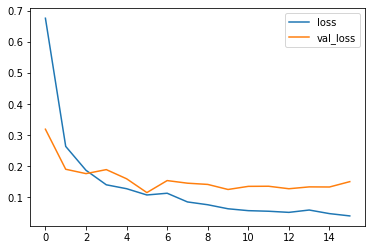

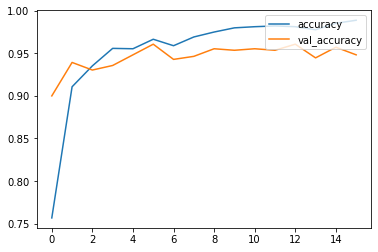

In [12]:
# Grafik acc dan val acc dari epoch 1 s/d 16

model.evaluate(val_ds)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='upper right')
plt.show()

# 4.2. Preparing for submission

In [13]:
# Melihat file submision_file.csv untuk mengatahui isi file

sub_csv ='./4-animal-classification/Sample_submission.csv'
path_test = './4-animal-classification/test/test'

In [14]:
df_sub = pd.read_csv(sub_csv)
image_id = df_sub['ID']
df_sub.head(10)

,ID,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [15]:
# Masing-masing gambar akan diperlakukan secara individual dan disimpan dalam daftar yang kemudian bergabung dengan ID file tersebut

from tensorflow.keras.preprocessing.image import load_img


# membuat daftar gambar untuk prediksi
labels = []


for i in image_id:
    image = load_img(path_test+'/'+str(i)+'.jpg', target_size=(224, 224))
    img = np.array(image)
    img = img / 255.0
    img = img.reshape(1,224,224,3)
    label = model.predict(img)
    label_id = label[0].tolist()
    
    labels.append(label_id.index(max(label_id)))


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 41ms/step


In [16]:
# we will replace the previous empty columns with the new predictions    
    
df_sub['Label'] = labels
df_sub.head(10)

,ID,Label
0,1,1
1,2,0
2,3,2
3,4,3
4,5,2
5,6,1
6,7,3
7,8,0
8,9,3
9,10,2


In [17]:
# # saving file
# df_sub.to_csv('submission_file.csv',index=False)

## 5. Model ResNet50

In [29]:
from keras.applications.resnet import ResNet50

# Membangun model dengan ResNet50
ModelResNet50 = tf.keras.applications.ResNet50(input_shape=(224 , 224, 3),
                                           include_top=False,
                                           weights='imagenet')
# merancang arsitektur ResNet50 dengan average pooling jenis arsitektur Fully-Connected Layer.
model = Sequential()
model.add(ModelResNet50)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(4, activation="softmax" , name="classification"))

In [30]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0005,momentum=0.9), 
            loss='categorical_crossentropy',
            metrics = ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                      

In [31]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=10, 
    min_delta=0.001, 
    mode='max',
    restore_best_weights=True
)

# early_stopping

In [32]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reducelr = ReduceLROnPlateau(monitor = "val_accuracy",factor = 0.3, patience = 3,
                            min_delta = 0.001,mode = 'auto',verbose=1)

## 5.1. Training and evaluating

In [33]:
history_ResNet = model.fit(train_ds , validation_data = val_ds , epochs = 16, callbacks=[early_stopping, reducelr])

Epoch 1/16
140/140 [==============================] - 961s 7s/step - loss: 0.7159 - accuracy: 0.7513 - val_loss: 1.4446 - val_accuracy: 0.3232 - lr: 5.0000e-04
Epoch 2/16
140/140 [==============================] - 948s 7s/step - loss: 0.2018 - accuracy: 0.9379 - val_loss: 1.4390 - val_accuracy: 0.3250 - lr: 5.0000e-04
Epoch 3/16
140/140 [==============================] - 948s 7s/step - loss: 0.1437 - accuracy: 0.9487 - val_loss: 1.3708 - val_accuracy: 0.3536 - lr: 5.0000e-04
Epoch 4/16
140/140 [==============================] - 790s 6s/step - loss: 0.0881 - accuracy: 0.9679 - val_loss: 0.9834 - val_accuracy: 0.5911 - lr: 5.0000e-04
Epoch 5/16
140/140 [==============================] - 835s 6s/step - loss: 0.0811 - accuracy: 0.9719 - val_loss: 0.7439 - val_accuracy: 0.7411 - lr: 5.0000e-04
Epoch 6/16
140/140 [==============================] - 1072s 8s/step - loss: 0.0718 - accuracy: 0.9754 - val_loss: 0.4435 - val_accuracy: 0.8589 - lr: 5.0000e-04
Epoch 7/16
140/140 [===================

35/35 [==============================] - 42s 1s/step - loss: 0.1460 - accuracy: 0.9571


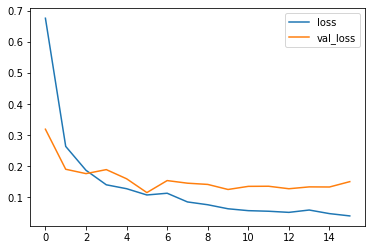

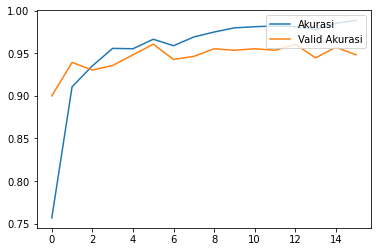

In [34]:
# Melihat grafik iterasi akurasi dan val akurasi data train

model.evaluate(val_ds)


plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Akurasi','Valid Akurasi'],loc='upper right')
plt.show()

## 5.2. Preparing for submission

In [40]:
sub_csv ='./4-animal-classification/Sample_submission.csv'
path_test = './4-animal-classification/test/test'

In [41]:
df_sub = pd.read_csv(sub_csv)
image_id = df_sub['ID']
df_sub.head(10)

,ID,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [42]:
# Masing-masing gambar akan diperlakukan secara individual dan disimpan dalam daftar yang kemudian bergabung dengan ID file tersebut

from tensorflow.keras.preprocessing.image import load_img


# membuat daftar yg diprediksi
labels = []


for i in image_id:
    image = load_img(path_test+'/'+str(i)+'.jpg', target_size=(224, 224))
    img = np.array(image)
    img = img / 255.0
    img = img.reshape(1,224,224,3)
    label = model.predict(img)
    label_id = label[0].tolist()
    
    labels.append(label_id.index(max(label_id)))


1/1 [==============================] - 0s 124ms/step


1/1 [==============================] - 0s 130ms/step


1/1 [==============================] - 0s 135ms/step


In [43]:
# we will replace the previous empty columns with the new predictions    
    
df_sub['Label'] = labels
df_sub.head(10)

,ID,Label
0,1,1
1,2,0
2,3,2
3,4,3
4,5,2
5,6,1
6,7,3
7,8,0
8,9,3
9,10,2


In [44]:
# Menyimpan file csv yg telah diperbarui
df_sub.to_csv('submission_file_ResNet50.csv',index=False)